<a href="https://colab.research.google.com/github/amansandhu408/deep-learning/blob/main/xception_5folds_98_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [ ]:
IMG_SIZE = 224
NUM_CLASSES = 3
VALID_EXT = (".png", ".jpg", ".jpeg")

BASE = "/kaggle/input/datasets/amansandhu408/spectrograms/spectrograms"
path_24 = os.path.join(BASE, "24GHz")
path_77 = os.path.join(BASE, "77GHz")
path_xe = os.path.join(BASE, "Xethru")


In [ ]:
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False
def load_three_radar_data(p1, p2, p3, classes):

    X1, X2, X3, Y = [], [], [], []

    for label, cls in enumerate(classes):

        d1 = os.path.join(p1, cls)
        d2 = os.path.join(p2, cls)
        d3 = os.path.join(p3, cls)

        f1 = sorted([f for f in os.listdir(d1) if f.lower().endswith(VALID_EXT)])
        f2 = sorted([f for f in os.listdir(d2) if f.lower().endswith(VALID_EXT)])
        f3 = sorted([f for f in os.listdir(d3) if f.lower().endswith(VALID_EXT)])

        min_len = min(len(f1), len(f2), len(f3))

        for i in range(min_len):

            p_1 = os.path.join(d1, f1[i])
            p_2 = os.path.join(d2, f2[i])
            p_3 = os.path.join(d3, f3[i])

            if not (is_valid_image(p_1) and is_valid_image(p_2) and is_valid_image(p_3)):
                continue

            img1 = np.array(Image.open(p_1).resize((IMG_SIZE, IMG_SIZE))) / 255.0
            img2 = np.array(Image.open(p_2).resize((IMG_SIZE, IMG_SIZE))) / 255.0
            img3 = np.array(Image.open(p_3).resize((IMG_SIZE, IMG_SIZE))) / 255.0

            X1.append(img1)
            X2.append(img2)
            X3.append(img3)
            Y.append(label)

    return np.array(X1), np.array(X2), np.array(X3), np.array(Y)


In [ ]:
classes = sorted(os.listdir(path_24))

X24, X77, Xxe, y_original = load_three_radar_data(
    path_24, path_77, path_xe, classes
)


In [ ]:
class_map = {
    'sitting': 0,
    'kneeling': 0,
    'bending': 0,
    'picking_up_object': 0,

    'limping': 1,
    'scissors_gait': 1,
    'short_steps': 1,

    'crawling': 2,
    'walking_towards_radar': 2,
    'walking_away_from_radar': 2,
    'walking_on_both_toes': 2
}

y_3class = np.array([class_map[classes[label]] for label in y_original])


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

I0000 00:00:1771224638.983035      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771224638.989302      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
def build_encoder():

    base = tf.keras.applications.Xception(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    base.trainable = True

    # Freeze lower layers
    for layer in base.layers[:-30]:
        layer.trainable = False

    # Freeze BatchNorm layers
    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)

    return models.Model(base.input, x)


In [ ]:
def attention_fusion(f24, f77, fxe):

    a24 = layers.Dense(1)(f24)
    a77 = layers.Dense(1)(f77)
    axe = layers.Dense(1)(fxe)

    concat = layers.Concatenate()([a24, a77, axe])
    weights = layers.Softmax()(concat)

    w24 = layers.Lambda(lambda x: x[:,0:1])(weights)
    w77 = layers.Lambda(lambda x: x[:,1:2])(weights)
    wxe = layers.Lambda(lambda x: x[:,2:3])(weights)

    f24 = layers.Multiply()([f24, w24])
    f77 = layers.Multiply()([f77, w77])
    fxe = layers.Multiply()([fxe, wxe])

    return layers.Add()([f24, f77, fxe])


In [ ]:
def build_model():

    enc24 = build_encoder()
    enc77 = build_encoder()
    encxe = build_encoder()

    in24 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    in77 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    inxe = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    aug24 = data_augmentation(in24)
    aug77 = data_augmentation(in77)
    augxe = data_augmentation(inxe)

    f24 = enc24(layers.GaussianNoise(0.02)(aug24))
    f77 = enc77(layers.GaussianNoise(0.02)(aug77))
    fxe = encxe(layers.GaussianNoise(0.02)(augxe))

    fused = attention_fusion(f24, f77, fxe)

    x = layers.Dense(512, activation="relu")(fused)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model([in24, in77, inxe], out)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=1e-4
    )

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )

    return model


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_no = 1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


========== Fold 1 ==========


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │ input_layer_11[0… │
│                     │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_3    │ (None, 224, 224,  │          0 │ sequential[3][0]  │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_4    │ (None, 224, 224,  │          0 │ sequential[4][0]  │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_5    │ (None, 224, 224,  │          0 │ sequential[5][0]  │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 2048)      │ 20,861,480 │ gaussian_noise_3… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 2048)      │ 20,861,480 │ gaussian_noise_4… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 2048)      │ 20,861,480 │ gaussian_noise_5… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │      2,049 │ functional_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │      2,049 │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      2,049 │ functional_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3)         │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ dense_8[0][0],    │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 3)         │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ softmax_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ softmax_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1)         │          0 │ softmax_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,716,350 (243.06 MB)

 Trainable params: 27,896,054 (106.42 MB)

 Non-trainable params: 35,820,296 (136.64 MB)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 584ms/step - accuracy: 0.5069 - loss: 1.0601 - val_accuracy: 0.3968 - val_loss: 1.0114
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 446ms/step - accuracy: 0.8671 - loss: 0.4786 - val_accuracy: 0.4603 - val_loss: 0.9362
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step - accuracy: 0.9075 - loss: 0.4232 - val_accuracy: 0.6667 - val_loss: 0.8515
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.9349 - loss: 0.3421 - val_accuracy: 0.6270 - val_loss: 0.8045
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.9333 - loss: 0.3338 - val_accuracy: 0.9524 - val_loss: 0.6609
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.9712 - loss: 0.2707 - val_accuracy: 0.9524 - val_loss: 0.5736
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.9442 - loss: 0.3201 - val_accuracy: 0.9603 - val_loss: 0.5144
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.9553 - loss: 0.3023 - val_accu

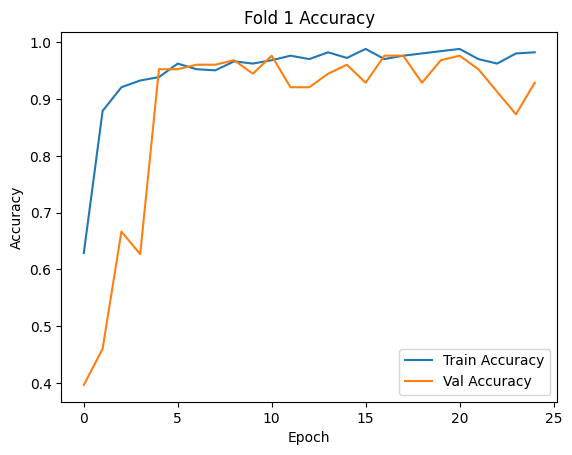

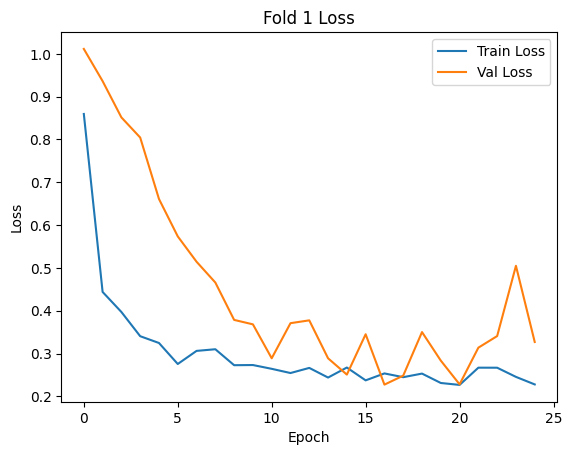


========== Fold 2 ==========


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_16[0… │
│ (Sequential)        │ 3)                │            │ input_layer_17[0… │
│                     │                   │            │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_6    │ (None, 224, 224,  │          0 │ sequential[6][0]  │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_7    │ (None, 224, 224,  │          0 │ sequential[7][0]  │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_8    │ (None, 224, 224,  │          0 │ sequential[8][0]  │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 2048)      │ 20,861,480 │ gaussian_noise_6… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_10       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_7… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_8… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      2,049 │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │      2,049 │ functional_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │      2,049 │ functional_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3)         │          0 │ dense_14[0][0],   │
│ (Concatenate)       │                   │            │ dense_15[0][0],   │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 3)         │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1)         │          0 │ softmax_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ softmax_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 1)         │          0 │ softmax_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,716,350 (243.06 MB)

 Trainable params: 27,896,054 (106.42 MB)

 Non-trainable params: 35,820,296 (136.64 MB)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - accuracy: 0.5178 - loss: 1.1611 - val_accuracy: 0.6984 - val_loss: 1.0099
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 445ms/step - accuracy: 0.7897 - loss: 0.5960 - val_accuracy: 0.8095 - val_loss: 0.9435
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.8254 - loss: 0.4847 - val_accuracy: 0.8095 - val_loss: 0.8157
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - accuracy: 0.8917 - loss: 0.4180 - val_accuracy: 0.8810 - val_loss: 0.6950
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.9509 - loss: 0.3244 - val_accuracy: 0.8571 - val_loss: 0.6397
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - accuracy: 0.9420 - loss: 0.3221 - val_accuracy: 0.9286 - val_loss: 0.5562
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.9484 - loss: 0.3000 - val_accuracy: 0.9206 - val_loss: 0.5381
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 433ms/step - accuracy: 0.9548 - loss: 0.3101 - val_accu

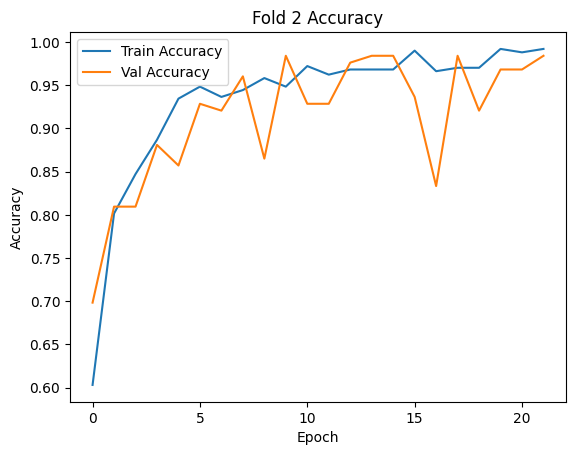

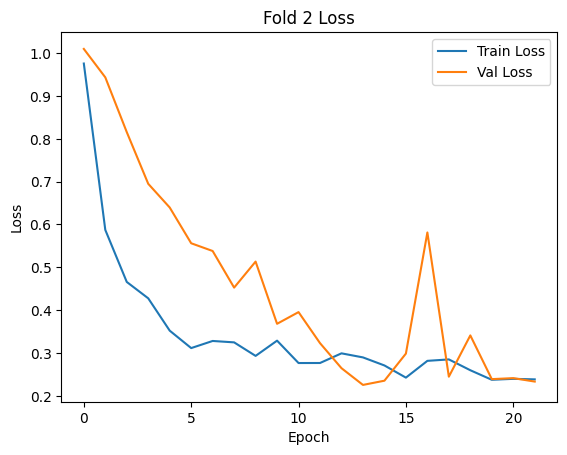


========== Fold 3 ==========


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_22[0… │
│ (Sequential)        │ 3)                │            │ input_layer_23[0… │
│                     │                   │            │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_9    │ (None, 224, 224,  │          0 │ sequential[9][0]  │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_10   │ (None, 224, 224,  │          0 │ sequential[10][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_11   │ (None, 224, 224,  │          0 │ sequential[11][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_13       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_9… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_14       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │      2,049 │ functional_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │      2,049 │ functional_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │      2,049 │ functional_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 3)         │          0 │ dense_21[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0],   │
│                     │                   │            │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_3 (Softmax) │ (None, 3)         │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 1)         │          0 │ softmax_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 1)         │          0 │ softmax_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 1)         │          0 │ softmax_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,716,350 (243.06 MB)

 Trainable params: 27,896,054 (106.42 MB)

 Non-trainable params: 35,820,296 (136.64 MB)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 622ms/step - accuracy: 0.5099 - loss: 1.0766 - val_accuracy: 0.3889 - val_loss: 1.0366
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 446ms/step - accuracy: 0.8192 - loss: 0.5266 - val_accuracy: 0.5238 - val_loss: 0.9615
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.8773 - loss: 0.4247 - val_accuracy: 0.6825 - val_loss: 0.8962
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.9152 - loss: 0.3494 - val_accuracy: 0.8651 - val_loss: 0.8109
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.9446 - loss: 0.3306 - val_accuracy: 0.9048 - val_loss: 0.7143
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - accuracy: 0.9332 - loss: 0.3233 - val_accuracy: 0.9524 - val_loss: 0.5930
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.9558 - loss: 0.2894 - val_accuracy: 0.7937 - val_loss: 0.6078
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 433ms/step - accuracy: 0.9324 - loss: 0.3260 - val_accu

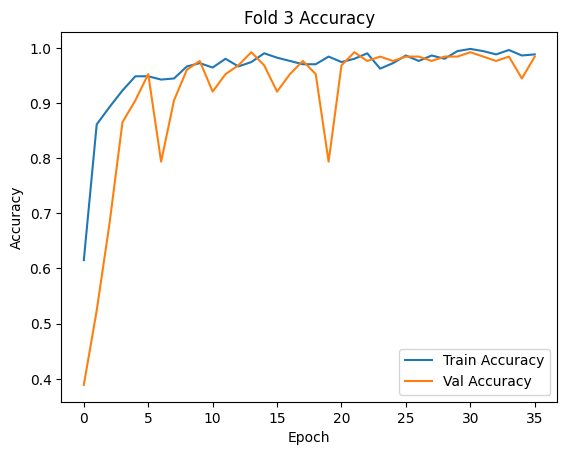

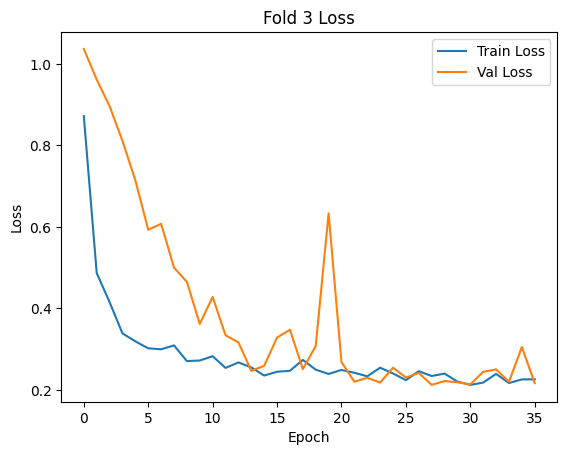


========== Fold 4 ==========


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_30      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_28[0… │
│ (Sequential)        │ 3)                │            │ input_layer_29[0… │
│                     │                   │            │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_12   │ (None, 224, 224,  │          0 │ sequential[12][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_13   │ (None, 224, 224,  │          0 │ sequential[13][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_14   │ (None, 224, 224,  │          0 │ sequential[14][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_17       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_18       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_19       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1)         │      2,049 │ functional_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │      2,049 │ functional_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1)         │      2,049 │ functional_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 3)         │          0 │ dense_28[0][0],   │
│ (Concatenate)       │                   │            │ dense_29[0][0],   │
│                     │                   │            │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_4 (Softmax) │ (None, 3)         │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 1)         │          0 │ softmax_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1)         │          0 │ softmax_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 1)         │          0 │ softmax_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,716,350 (243.06 MB)

 Trainable params: 27,896,054 (106.42 MB)

 Non-trainable params: 35,820,296 (136.64 MB)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - accuracy: 0.4669 - loss: 1.2067 - val_accuracy: 0.6032 - val_loss: 0.9957
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 445ms/step - accuracy: 0.8485 - loss: 0.4981 - val_accuracy: 0.6746 - val_loss: 0.9600
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.8906 - loss: 0.4365 - val_accuracy: 0.7619 - val_loss: 0.8391
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - accuracy: 0.9190 - loss: 0.3935 - val_accuracy: 0.7222 - val_loss: 0.8187
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.8952 - loss: 0.3811 - val_accuracy: 0.9683 - val_loss: 0.6905
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.9440 - loss: 0.3261 - val_accuracy: 0.9683 - val_loss: 0.5865
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.9362 - loss: 0.3831 - val_accuracy: 0.9048 - val_loss: 0.5555
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - accuracy: 0.9560 - loss: 0.3058 - val_accu

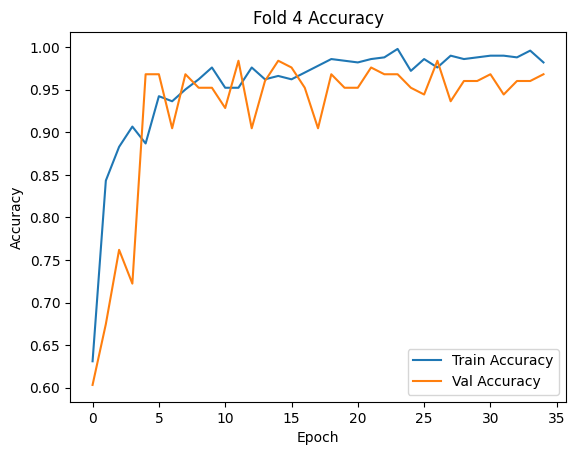

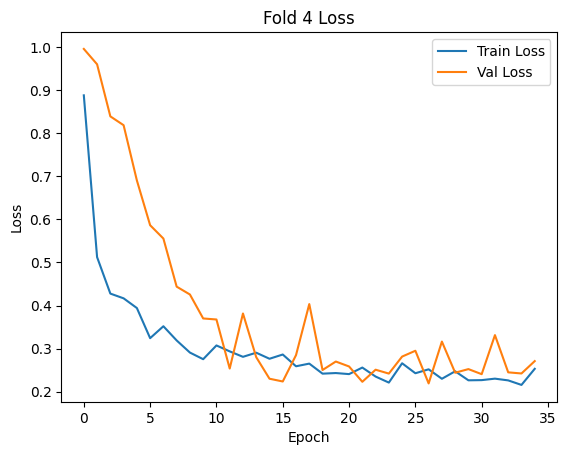


========== Fold 5 ==========


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_35      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_36      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_34[0… │
│ (Sequential)        │ 3)                │            │ input_layer_35[0… │
│                     │                   │            │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_15   │ (None, 224, 224,  │          0 │ sequential[15][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_16   │ (None, 224, 224,  │          0 │ sequential[16][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_17   │ (None, 224, 224,  │          0 │ sequential[17][0] │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_21       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_22       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_23       │ (None, 2048)      │ 20,861,480 │ gaussian_noise_1… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │      2,049 │ functional_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 1)         │      2,049 │ functional_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 1)         │      2,049 │ functional_23[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 3)         │          0 │ dense_35[0][0],   │
│ (Concatenate)       │                   │            │ dense_36[0][0],   │
│                     │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_5 (Softmax) │ (None, 3)         │          0 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 1)         │          0 │ softmax_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 1)         │          0 │ softmax_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, 1)         │          0 │ softmax_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,716,350 (243.06 MB)

 Trainable params: 27,896,054 (106.42 MB)

 Non-trainable params: 35,820,296 (136.64 MB)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 597ms/step - accuracy: 0.5061 - loss: 1.1606 - val_accuracy: 0.6270 - val_loss: 0.9516
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 447ms/step - accuracy: 0.7731 - loss: 0.6205 - val_accuracy: 0.7063 - val_loss: 0.8745
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.8608 - loss: 0.4248 - val_accuracy: 0.8968 - val_loss: 0.7459
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9134 - loss: 0.3593 - val_accuracy: 0.8254 - val_loss: 0.7202
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 422ms/step - accuracy: 0.9327 - loss: 0.3367 - val_accuracy: 0.8968 - val_loss: 0.6612
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - accuracy: 0.9148 - loss: 0.3538 - val_accuracy: 0.9048 - val_loss: 0.5649
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 432ms/step - accuracy: 0.9313 - loss: 0.3347 - val_accuracy: 0.9444 - val_loss: 0.4469
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.9639 - loss: 0.2912 - val_accu

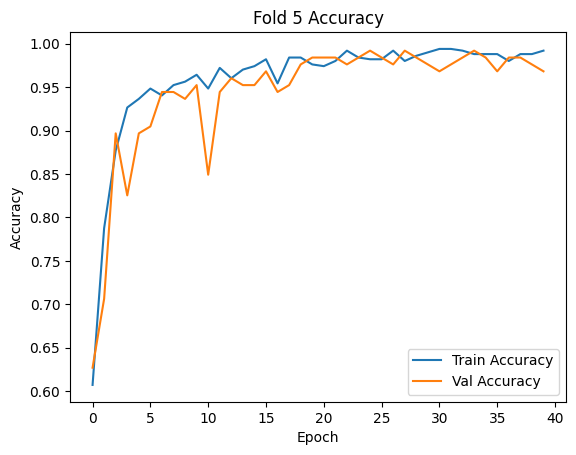

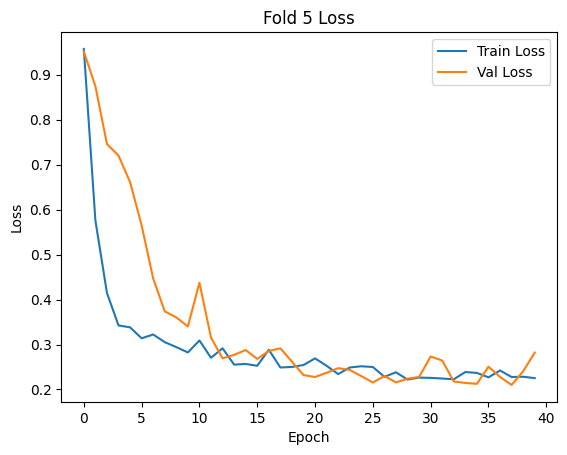

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_f1_scores = []

all_true = []
all_pred = []

fold_no = 1

for train_index, val_index in skf.split(X24, y_3class):

    print(f"\n========== Fold {fold_no} ==========")

    X24_train, X24_val = X24[train_index], X24[val_index]
    X77_train, X77_val = X77[train_index], X77[val_index]
    Xxe_train, Xxe_val = Xxe[train_index], Xxe[val_index]

    y_train, y_val = y_3class[train_index], y_3class[val_index]

    y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_val_cat   = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))

    model = build_model()

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    )

    #training
    start_time = time.time()

    history = model.fit(
        [X24_train, X77_train, Xxe_train],
        y_train_cat,
        validation_data=([X24_val, X77_val, Xxe_val], y_val_cat),
        epochs=40,
        batch_size=16,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=1
    )

    end_time = time.time()


    #inference time
    start_inf = time.time()
    preds = model.predict([X24_val, X77_val, Xxe_val])
    end_inf = time.time()

    # Evaluation
    val_loss, val_acc = model.evaluate(
        [X24_val, X77_val, Xxe_val],
        y_val_cat,
        verbose=0
    )

    fold_accuracies.append(val_acc)

    # Predictions
    y_pred = model.predict([X24_val, X77_val, Xxe_val])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true = y_val

    all_true.extend(y_true)
    all_pred.extend(y_pred_cls)

    # F1 Score
    f1 = f1_score(y_true, y_pred_cls, average='weighted')
    fold_f1_scores.append(f1)

    print(f"Fold {fold_no} Accuracy: {val_acc*100:.2f}%")
    print(f"Fold {fold_no} F1 Score: {f1:.4f}")
    print(f"Training Time: {end_time - start_time:.2f} sec")
    print(f"Inference Time: {end_inf - start_inf:.2f} sec")
    print("Per Sample:", (end_inf - start_inf)/len(X24_val), " sec")

    # 🔹 Accuracy vs Val Accuracy Plot
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {fold_no} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # 🔹 Loss vs Val Loss Plot
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold_no} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    fold_no += 1


In [ ]:
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)

mean_f1 = np.mean(fold_f1_scores)
std_f1  = np.std(fold_f1_scores)

print("\n==============================")
print(f"5-Fold Mean Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}")
print(f"5-Fold Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print("==============================")


5-Fold Mean Accuracy: 98.10% ± 0.39
5-Fold Mean F1 Score: 0.9809 ± 0.0039


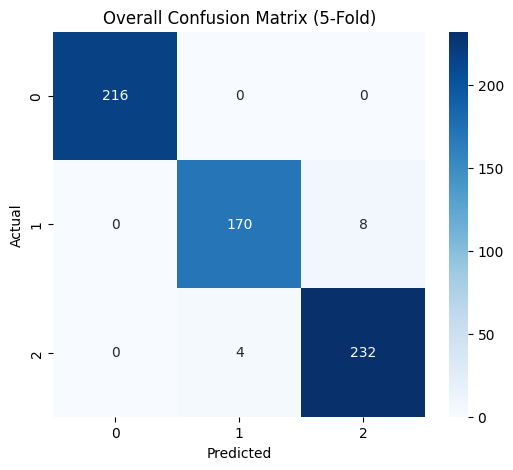


Classification Report (All Folds Combined):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       0.98      0.96      0.97       178
           2       0.97      0.98      0.97       236

    accuracy                           0.98       630
   macro avg       0.98      0.98      0.98       630
weighted avg       0.98      0.98      0.98       630



In [ ]:
cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Overall Confusion Matrix (5-Fold)")
plt.show()

print("\nClassification Report (All Folds Combined):\n")
print(classification_report(all_true, all_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 903ms/step
Feature shape: (126, 64)


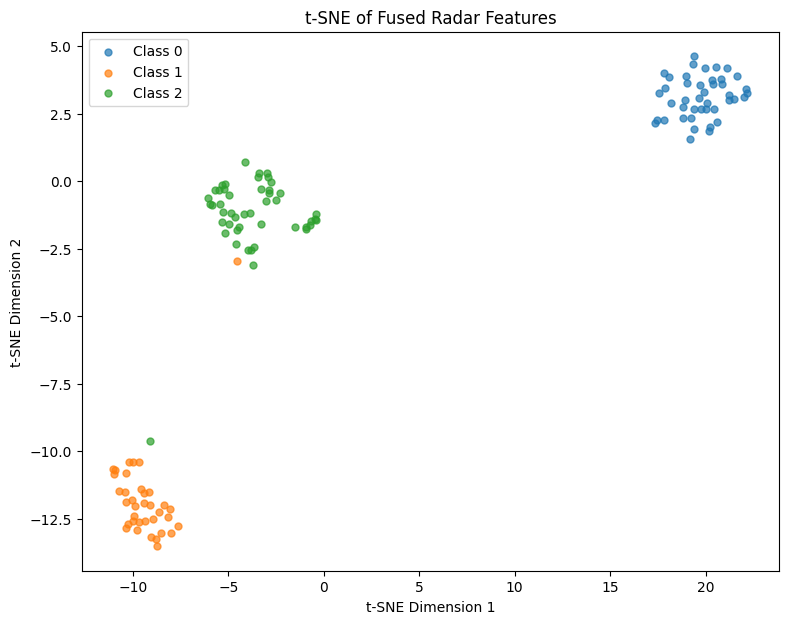

In [ ]:
# Extract features
feature_layer = model.layers[-2].output

feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=feature_layer
)

features = feature_extractor.predict(
    [X24_val, X77_val, Xxe_val],
    batch_size=16,
    verbose=1
)

print("Feature shape:", features.shape)

# True validation labels
y_true = np.argmax(y_val_cat, axis=1)

# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    init='pca'
)

features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(9, 7))

for class_id in range(NUM_CLASSES):
    idx = y_true == class_id
    plt.scatter(
        features_2d[idx, 0],
        features_2d[idx, 1],
        label=f"Class {class_id}",
        s=25,
        alpha=0.7
    )

plt.legend()
plt.title("t-SNE of Fused Radar Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
